## Homework Reflection 9

1. Write some code that will use a simulation to estimate the standard deviation of the coefficient when there is heteroskedasticity.  
Compare these standard errors to those found via statsmodels OLS or a similar linear regression model.

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt

In [2]:
# Create a simulated dataset with heteroskedasticity
def simulate(n_simulations=1000, high_corr=False):
    np.random.seed(42)
    coefficients = []
    se_regular = []
    se_robust = []

    for i in range(n_simulations):

        # Generate data for each simulation
        W = np.random.normal(0, 1, 1000)
        X = W + np.random.normal(0, 1, 1000)

        # Introduce heteroskedasticity
        error = np.random.normal(0, 3 * np.abs(X), 1000)
        Y = 2 * X - W + np.random.normal(0, 10, 1000) + error

        # Create DataFrame and run regression
        df = pd.DataFrame({'Y': Y, 'X': X, 'W': W})
        const_X = sm.add_constant(df[['X', 'W']])
        model = sm.OLS(df['Y'], const_X).fit()

        # Store the coefficents, and standard errors
        coefficients.append(model.params['X'])
        se_regular.append(model.bse['X'])

        # Fit model with robust standard errors (heteroskedasticity-consistent)
        model_robust = sm.OLS(df['Y'], const_X).fit(cov_type='HC3')
        se_robust.append(model_robust.bse['X'])

    # Calculate empirical standard deviation (true standard error)
    empirical_std = np.std(coefficients)
    
    # Calculate average of the estimated standard errors
    avg_se_regular = np.mean(se_regular)
    avg_se_robust = np.mean(se_robust)
    
    return {
        'coefficients': coefficients,
        'empirical_std': empirical_std,
        'avg_se_regular': avg_se_regular,
        'avg_se_robust': avg_se_robust,
        'se_regular_all': se_regular,
        'se_robust_all': se_robust
    }

In [3]:
# Run the simulation
results = simulate(n_simulations=1000)

print("=== Heteroskedasticity Analysis Results ===")
print(f"True coefficient value: 2.0")
print(f"Empirical mean of estimates: {np.mean(results['coefficients']):.4f}")
print(f"Empirical standard deviation: {results['empirical_std']:.4f}")
print()
print("Standard Error Estimates:")
print(f"Regular OLS SE (average): {results['avg_se_regular']:.4f}")
print(f"Robust SE (average): {results['avg_se_robust']:.4f}")
print()
print("Comparison to Empirical Standard Deviation:")
print(f"Regular OLS SE / Empirical SD: {results['avg_se_regular'] / results['empirical_std']:.4f}")
print(f"Robust SE / Empirical SD: {results['avg_se_robust'] / results['empirical_std']:.4f}")
print()

# Show which is closer to the true standard deviation
regular_diff = abs(results['avg_se_regular'] - results['empirical_std'])
robust_diff = abs(results['avg_se_robust'] - results['empirical_std'])

print(f"Absolute difference from empirical SD:")
print(f"Regular OLS: {regular_diff:.4f}")
print(f"Robust SE: {robust_diff:.4f}")

if robust_diff < regular_diff:
    print("Robust standard errors are closer to the true standard deviation")
else:
    print("Regular OLS standard errors are closer to the true standard deviation")

=== Heteroskedasticity Analysis Results ===
True coefficient value: 2.0
Empirical mean of estimates: 1.9953
Empirical standard deviation: 0.3717

Standard Error Estimates:
Regular OLS SE (average): 0.3439
Robust SE (average): 0.3696

Comparison to Empirical Standard Deviation:
Regular OLS SE / Empirical SD: 0.9252
Robust SE / Empirical SD: 0.9942

Absolute difference from empirical SD:
Regular OLS: 0.0278
Robust SE: 0.0021
Robust standard errors are closer to the true standard deviation


2. Write some code that will use a simulation to estimate the standard deviation of the coefficient when errors are highly correlated / non-independent.
Compare these standard errors to those found via statsmodels OlS or a similar linear regression model.

Show that if the correlation between coefficients is high enough, then the estimated standard deviation of the coefficient, using bootstrap errors, 
might not match that found by a full simulation of the Data Generating Process.  (This can be fixed if you have a huge amount of data for the bootstrap simulation.)

In [4]:
# Simulate with highly correlated errors and compare bootstrap SE to simulation SE
def simulate_high_corr(n_simulations=1000):
    np.random.seed(42)
    coefficients = []
    se_regular = []
    se_robust = []

    for i in range(n_simulations):

        # Generate highly correlated errors
        W = np.random.normal(0, 1, 1000)
        X = W + np.random.normal(0, 1, 1000)
        error = np.random.normal(0, 1, 1000)

        # Add strong autocorrelation to error
        error = 0.9 * np.roll(error, 1) + error
        Y = 2 * X - W + np.random.normal(0, 10, 1000) + error

        # Create DataFrame and run regression
        df = pd.DataFrame({'Y': Y, 'X': X, 'W': W})
        const_X = sm.add_constant(df[['X', 'W']])
        model = sm.OLS(df['Y'], const_X).fit()

        # Store the coefficients and standard errors
        coefficients.append(model.params['X'])
        se_regular.append(model.bse['X'])
        model_robust = sm.OLS(df['Y'], const_X).fit(cov_type='HC3')
        se_robust.append(model_robust.bse['X'])

    empirical_std = np.std(coefficients)
    avg_se_regular = np.mean(se_regular)
    avg_se_robust = np.mean(se_robust)
    
    return empirical_std, avg_se_regular, avg_se_robust, coefficients

# Run the simulation for highly correlated errors
empirical_std, avg_se_regular, avg_se_robust, coeffs = simulate_high_corr(n_simulations=1000)

# Now, run a single simulation and estimate SE using bootstrap
W = np.random.normal(0, 1, 1000)
X = W + np.random.normal(0, 1, 1000)
error = np.random.normal(0, 1, 1000)
error = 0.9 * np.roll(error, 1) + error
Y = 2 * X - W + np.random.normal(0, 10, 1000) + error
df = pd.DataFrame({'Y': Y, 'X': X, 'W': W})
const_X = sm.add_constant(df[['X', 'W']])

# Bootstrap standard error
n_boot = 500
boot_coefs = []
for _ in range(n_boot):
    idx = np.random.choice(len(df), len(df), replace=True)
    sample = df.iloc[idx]
    model = sm.OLS(sample['Y'], sm.add_constant(sample[['X', 'W']])).fit()
    boot_coefs.append(model.params['X'])
bootstrap_se = np.std(boot_coefs)

print("=== Highly Correlated Errors Analysis ===")
print(f"Empirical std from simulation: {empirical_std:.4f}")
print(f"Average OLS SE: {avg_se_regular:.4f}")
print(f"Average robust SE: {avg_se_robust:.4f}")
print(f"Bootstrap SE from one sample: {bootstrap_se:.4f}")
print()
print("Bootstrap SE / Empirical SD: {:.4f}".format(bootstrap_se / empirical_std))
print("If this ratio is far from 1, bootstrap SE does not match simulation SE due to high correlation.")

=== Highly Correlated Errors Analysis ===
Empirical std from simulation: 0.3181
Average OLS SE: 0.3195
Average robust SE: 0.3199
Bootstrap SE from one sample: 0.3033

Bootstrap SE / Empirical SD: 0.9533
If this ratio is far from 1, bootstrap SE does not match simulation SE due to high correlation.


## Homework Reflection 10

We are skipping this one, this time.

## Homework Reflection 11

1. Construct a dataset for an event study where the value, derivative, and second derivative of a trend all change discontinuously (suddenly) after an event.\
Build a model that tries to decide whether the event is real (has a nonzero effect) using:\
(a) only the value,\
(b) the value, derivative, and second derivative.\
Which of these models is better at detecting and/or quantifying the impact of the event?  (What might "better" mean here?)

In [90]:
def construct_event_study_dataset(n=1000, event_time=500, noise_level=0.5):
    np.random.seed(42)
    time = np.arange(n)

    # Initialize the series
    y = np.zeros(n)

    # Pre-event parameters
    pre_intercept = 20.0      
    pre_slope = 0.06          
    pre_curvature = 0.0001   
    
    # Post-event parameters
    post_intercept = pre_intercept - 5.0   
    post_slope = pre_slope - 0.05          
    post_curvature = pre_curvature - 0.0003  
    
    for t in range(n):
        if t < event_time:
            # Pre-event
            y[t] = (pre_intercept + 
                   pre_slope * t + 
                   pre_curvature * t**2)
        else:
            # Post-event
            t_since_event = t - event_time
            
            # Calculate what the pre-event trend would have been at event_time
            pre_event_value = (pre_intercept + 
                             pre_slope * event_time + 
                             pre_curvature * event_time**2)
            
            # Start post-event trend from the new intercept level
            y[t] = (post_intercept + 
                   post_slope * t_since_event + 
                   post_curvature * t_since_event**2)
    
    # Add noise
    noise = np.random.normal(0, noise_level, n)
    y_noisy = y + noise
    
    # Calculate true derivatives for comparison
    true_derivative = np.zeros(n)
    true_second_derivative = np.zeros(n)
    
    for t in range(n):
        if t < event_time:
            true_derivative[t] = pre_slope + 2 * pre_curvature * t
            true_second_derivative[t] = 2 * pre_curvature
        else:
            t_since_event = t - event_time
            true_derivative[t] = post_slope + 2 * post_curvature * t_since_event
            true_second_derivative[t] = 2 * post_curvature
    
    df = pd.DataFrame({
        'event': (time >= event_time).astype(int),
        'value': y_noisy,
        'derivative': true_derivative,
        'second_derivative': true_second_derivative
    }).reset_index(drop=True)

    return df

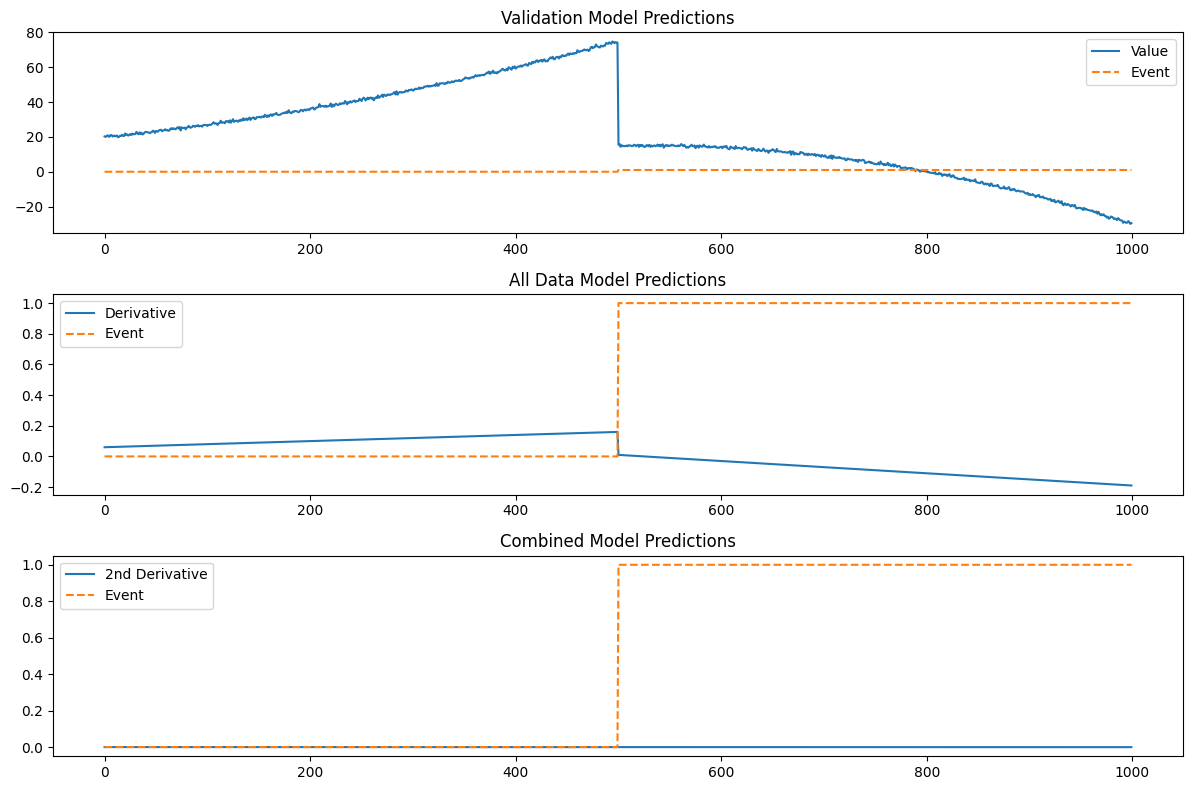

In [91]:
# Create the dataset
data = construct_event_study_dataset()

# Plot all three linecharts
plt.figure(figsize=(12, 8))

# Plot the validation model predictions
plt.subplot(3, 1, 1)
plt.plot(data['value'], label='Value')
plt.plot(data['event'], label='Event', linestyle='--')
plt.title('Validation Model Predictions')
plt.legend()

# Plot the all data model predictions
plt.subplot(3, 1, 2)
plt.plot(data['derivative'], label='Derivative')
plt.plot(data['event'], label='Event', linestyle='--')
plt.title('All Data Model Predictions')
plt.legend()

# Plot the combined model predictions
plt.subplot(3, 1, 3)
plt.plot(data['second_derivative'], label='2nd Derivative')
plt.plot(data['event'], label='Event', linestyle='--')
plt.title('Combined Model Predictions')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
# Create a model that predicts the event
def predict_event(data, all=True):
    
    # Prepare the data
    if all is True:
        X = data[['value', 'derivative', 'second_derivative']]
    else:
        X = data[['value']]

    y = data['event']

    # Add a constant term for the intercept
    X = sm.add_constant(X)

    # Fit the model
    model = sm.OLS(y, X)
    result = model.fit()
    
    return result.params['value']

In [61]:
# Model summary for just the value fit model
print("Validation Model Summary:")
print(predict_event(data, all=False))

Validation Model Summary:
-0.015872389921651832


In [ ]:
# Model summary for all features
print("\nAll Data Model Summary:")
print(predict_event(data, all=True))


All Data Model Summary:
-1.3889442981168676e-15


The value model is better at detecting the event because it has the greatest non-zero value. Better in this instance refers to detecting the event, rather than which model best fits the data for predictive reasons.

2. Construct a dataset in which there are three groups whose values each increase discontinuously (suddenly) by the same amount at a shared event; they change in parallel
over time, but they have different starting values.  Create a model that combines group fixed effects with an event study, as suggested in the online reading.
Explain what you did, how the model works, and how it accounts for both baseline differences and the common event effect.

In [93]:
def construct_three_group_dataset(n_sims=1000, event_time=500, common_effect=5.0, noise=0.3):
    np.random.seed(0)
    
    # Group parameters
    groups = ['A', 'B', 'C']
    baseline_levels = [10.0, 15.0, 20.0]
    common_slope = 0.02
    
    # Initialize lists to store data
    all_data = []
    
    for i, group in enumerate(groups):
        # Time points for this group
        time = np.arange(n_sims)
        
        # Base trend (same slope for all groups, different intercepts)
        y_base = baseline_levels[i] + common_slope * time
        
        # Add common event effect after event_time
        event_indicator = (time >= event_time).astype(int)
        y_with_event = y_base + common_effect * event_indicator
        
        # Add noise
        noise_e = np.random.normal(0, noise, n_sims)
        y_final = y_with_event + noise_e
        
        # Create group data
        group_data = pd.DataFrame({
            'group': group,
            'time': time,
            'y': y_final,
            'event': event_indicator,
            'baseline_level': baseline_levels[i]
        })
        
        all_data.append(group_data)
    
    # Combine all groups
    df = pd.concat(all_data, ignore_index=True)

    return df, {
        'common_effect': common_effect,
        'baseline_levels': baseline_levels,
        'common_slope': common_slope,
        'event_time': event_time
    }

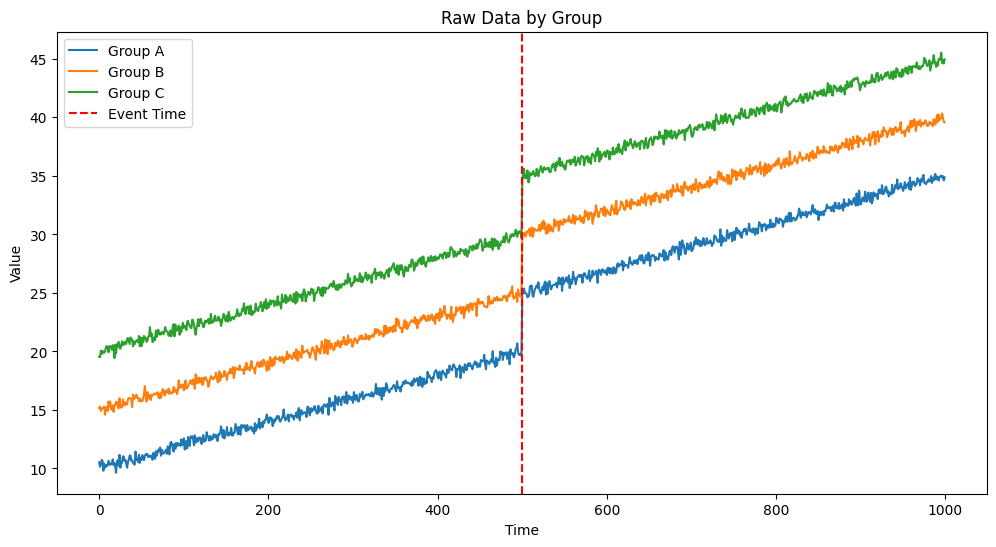

In [94]:
# Visualize the groups on a line chart
df_5, df_5_params = construct_three_group_dataset(n_sims=1000, event_time=500, common_effect=5.0, noise=0.3)

# Plot the raw data
plt.figure(figsize=(12, 6))
for group in df_5['group'].unique():
    plt.plot(df_5[df_5['group'] == group]['time'], df_5[df_5['group'] == group]['y'], label=f'Group {group}')
plt.axvline(x=500, color='red', linestyle='--', label='Event Time')
plt.title('Raw Data by Group')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [99]:
def create_group_fixed_effects_model(df, params):
    # Create dummy variables for groups (excluding one as reference)
    df_model = df.copy()
    
    # Ensure all numeric columns are properly typed
    df_model['time'] = pd.to_numeric(df_model['time'])
    df_model['y'] = pd.to_numeric(df_model['y'])
    df_model['event'] = pd.to_numeric(df_model['event'])
    
    # Create dummy variables
    df_model = pd.get_dummies(df_model, columns=['group'], prefix='group', drop_first=True)
    
    # Ensure dummy variables are numeric (0/1 integers)
    dummy_cols = [col for col in df_model.columns if col.startswith('group_')]
    for col in dummy_cols:
        df_model[col] = df_model[col].astype(int)
    
    # Model 1: Without event (baseline model)
    X_baseline = df_model[['time'] + dummy_cols].copy()
    X_baseline = sm.add_constant(X_baseline)
    model_baseline = sm.OLS(df_model['y'].values, X_baseline.values).fit()
    
    # Model 2: With event (event study model)
    X_event = df_model[['time'] + dummy_cols + ['event']].copy()
    X_event = sm.add_constant(X_event)
    model_event = sm.OLS(df_model['y'].values, X_event.values).fit()
    
    # Model 3: Separate group-specific event effects (interaction model)
    for col in dummy_cols:
        df_model[f'event_{col}'] = df_model['event'] * df_model[col]
    
    interaction_cols = [f'event_{col}' for col in dummy_cols]
    X_interaction = df_model[['time'] + dummy_cols + ['event'] + interaction_cols].copy()
    X_interaction = sm.add_constant(X_interaction)
    model_interaction = sm.OLS(df_model['y'].values, X_interaction.values).fit()
    
    return {
        'baseline': model_baseline,
        'event': model_event,
        'interaction': model_interaction,
        'df_model': df_model
    }

In [106]:
def analyze_group_fixed_effects(df, params, models):
    """
    Analyze the group fixed effects event study
    """
    print("=== GROUP FIXED EFFECTS EVENT STUDY ANALYSIS ===\n")
    
    # True parameters
    print("TRUE PARAMETERS:")
    print(f"Common event effect: {params['common_effect']:.2f}")
    print(f"Baseline levels: {params['baseline_levels']}")
    print(f"Common slope: {params['common_slope']:.4f}")
    print(f"Event time: {params['event_time']}")
    
    # Model results
    print(f"\nMODEL RESULTS:")
    
    print(f"\n1. BASELINE MODEL (No Event):")
    print(f"   Intercept (Group A baseline): {models['baseline'].params[0]:.4f}")
    
    # Get dummy column names dynamically
    dummy_cols = [col for col in models['df_model'].columns if col.startswith('group_')]
    
    # Print group effects
    for i, col in enumerate(dummy_cols, 1):
        group_name = col.replace('group_', '')
        print(f"   Group {group_name} effect: {models['baseline'].params[i+1]:.4f}")
    
    print(f"   Time trend: {models['baseline'].params[1]:.6f}")
    print(f"   R-squared: {models['baseline'].rsquared:.4f}")
    
    print(f"\n2. EVENT STUDY MODEL (Common Event Effect):")
    print(f"   Intercept (Group A baseline): {models['event'].params[0]:.4f}")
    
    # Print group effects for event model
    for i, col in enumerate(dummy_cols, 1):
        group_name = col.replace('group_', '')
        print(f"   Group {group_name} effect: {models['event'].params[i+1]:.4f}")
    
    print(f"   Time trend: {models['event'].params[1]:.6f}")
    
    # Event effect is the last parameter before interactions
    event_param_idx = 2 + len(dummy_cols)
    print(f"   EVENT EFFECT: {models['event'].params[event_param_idx]:.4f}")
    print(f"   Event t-statistic: {models['event'].tvalues[event_param_idx]:.4f}")
    print(f"   Event p-value: {models['event'].pvalues[event_param_idx]:.6f}")
    print(f"   R-squared: {models['event'].rsquared:.4f}")
    
    print(f"\n3. INTERACTION MODEL (Group-Specific Event Effects):")
    print(f"   Event effect (Group A): {models['interaction'].params[event_param_idx]:.4f}")
    
    # Check for interaction terms
    interaction_cols = [f'event_{col}' for col in dummy_cols]
    
    for i, col in enumerate(interaction_cols):
        if col in models['df_model'].columns:
            group_name = col.replace('event_group_', '').replace('event_group', '')
            interaction_param_idx = event_param_idx + 1 + i
            if interaction_param_idx < len(models['interaction'].params):
                print(f"   Additional event effect (Group {group_name}): {models['interaction'].params[interaction_param_idx]:.4f}")
    
    print(f"   R-squared: {models['interaction'].rsquared:.4f}")
    
    # Test for group-specific effects if interactions exist
    try:
        if len(interaction_cols) > 0 and all(col in models['df_model'].columns for col in interaction_cols):
            f_test = models['interaction'].f_test(interaction_cols)
            print(f"   F-test for group-specific effects: F={f_test.fvalue:.4f}, p={f_test.pvalue:.6f}")
    except:
        print("   F-test could not be performed")
    
    print(f"\nMODEL INTERPRETATION:")
    print(f"• Group fixed effects capture different baseline levels")
    print(f"• Common time trend estimated as {models['event'].params[1]:.6f}")
    print(f"• Event effect estimated as {models['event'].params[event_param_idx]:.4f} (true: {params['common_effect']:.2f})")
    print(f"• Model successfully separates group differences from event effect")

In [109]:
def plot_three_group_analysis(df, params, models):
    """
    Create comprehensive plots for three-group analysis
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    colors = {'A': 'blue', 'B': 'red', 'C': 'green'}
    
    # Plot 1: Raw data by group
    for group in ['A', 'B', 'C']:
        group_data = df[df['group'] == group]
        axes[0,0].scatter(group_data['time'], group_data['y'], 
                         alpha=0.6, s=20, color=colors[group], label=f'Group {group}')
    
    axes[0,0].axvline(x=params['event_time'], color='black', linestyle='--', alpha=0.7, label='Event time')
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Value')
    axes[0,0].set_title('Raw Data by Group')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Fitted values from event model
    df_plot = models['df_model'].copy()
    df_plot['fitted'] = models['event'].fittedvalues
    
    # Need to map back to original group labels
    dummy_cols = [col for col in df_plot.columns if col.startswith('group_')]
    
    # Reconstruct group labels
    df_plot['group_reconstructed'] = 'A'  # Default to reference group
    for col in dummy_cols:
        group_name = col.replace('group_', '')
        df_plot.loc[df_plot[col] == 1, 'group_reconstructed'] = group_name
    
    for group in ['A', 'B', 'C']:
        group_data = df_plot[df_plot['group_reconstructed'] == group].sort_values('time')
        if len(group_data) > 0:
            axes[0,1].plot(group_data['time'], group_data['fitted'], 
                          color=colors[group], linewidth=2, label=f'Group {group} fitted')
    
    axes[0,1].axvline(x=params['event_time'], color='black', linestyle='--', alpha=0.7, label='Event time')
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel('Fitted Value')
    axes[0,1].set_title('Model Fits (Event Study)')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: Residuals by group
    df_plot['residuals'] = models['event'].resid
    
    for group in ['A', 'B', 'C']:
        group_data = df_plot[df_plot['group_reconstructed'] == group]
        if len(group_data) > 0:
            axes[0,2].scatter(group_data['time'], group_data['residuals'], 
                             alpha=0.6, s=15, color=colors[group], label=f'Group {group}')
    
    axes[0,2].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[0,2].axvline(x=params['event_time'], color='black', linestyle='--', alpha=0.7)
    axes[0,2].set_xlabel('Time')
    axes[0,2].set_ylabel('Residuals')
    axes[0,2].set_title('Residuals by Group')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)
    
    # Plot 4: Group means over time
    window = 20
    for group in ['A', 'B', 'C']:
        group_data = df[df['group'] == group].sort_values('time')
        rolling_mean = group_data['y'].rolling(window=window, center=True).mean()
        axes[1,0].plot(group_data['time'], rolling_mean, 
                      color=colors[group], linewidth=2, label=f'Group {group} (rolling mean)')
    
    axes[1,0].axvline(x=params['event_time'], color='black', linestyle='--', alpha=0.7, label='Event time')
    axes[1,0].set_xlabel('Time')
    axes[1,0].set_ylabel('Rolling Mean')
    axes[1,0].set_title(f'Rolling Means (window={window})')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 5: Model comparison
    model_names = ['Baseline', 'Event Study', 'Interaction']
    r_squared = [models['baseline'].rsquared, models['event'].rsquared, models['interaction'].rsquared]
    aic = [models['baseline'].aic, models['event'].aic, models['interaction'].aic]
    
    x = np.arange(len(model_names))
    width = 0.35
    
    axes[1,1].bar(x - width/2, r_squared, width, label='R-squared', alpha=0.8, color='skyblue')
    ax2 = axes[1,1].twinx()
    ax2.bar(x + width/2, aic, width, label='AIC', alpha=0.8, color='orange')
    
    axes[1,1].set_xlabel('Model')
    axes[1,1].set_ylabel('R-squared', color='blue')
    ax2.set_ylabel('AIC', color='orange')
    axes[1,1].set_title('Model Comparison')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(model_names)
    axes[1,1].legend(loc='upper left')
    ax2.legend(loc='upper right')
    
    # Plot 6: Event effect by group
    event_effects = []
    group_labels = []
    
    # Get event effect parameter index
    dummy_cols = [col for col in models['df_model'].columns if col.startswith('group_')]
    event_param_idx = 2 + len(dummy_cols)
    
    # Group A (reference) - from event study model
    event_effects.append(models['event'].params[event_param_idx])
    group_labels.append('Group A')
    
    # Check if interaction model has group-specific effects
    interaction_cols = [f'event_{col}' for col in dummy_cols if f'event_{col}' in models['df_model'].columns]
    
    if len(interaction_cols) > 0:
        # Use interaction model results
        base_effect = models['interaction'].params[event_param_idx]
        event_effects[0] = base_effect  # Update Group A
        
        for i, col in enumerate(interaction_cols):
            group_name = col.replace('event_group_', '')
            interaction_param_idx = event_param_idx + 1 + i
            if interaction_param_idx < len(models['interaction'].params):
                total_effect = base_effect + models['interaction'].params[interaction_param_idx]
                event_effects.append(total_effect)
                group_labels.append(f'Group {group_name}')
    else:
        # All groups have same effect (from event study model)
        for group in ['B', 'C']:
            event_effects.append(models['event'].params[event_param_idx])
            group_labels.append(f'Group {group}')
    
    # Ensure we have the right number of effects
    if len(event_effects) != 3:
        event_effects = [models['event'].params[event_param_idx]] * 3
        group_labels = ['Group A', 'Group B', 'Group C']
    
    bars = axes[1,2].bar(group_labels, event_effects, 
                        color=[colors['A'], colors['B'], colors['C']], alpha=0.7)
    axes[1,2].axhline(y=params['common_effect'], color='red', linestyle='--', 
                     linewidth=2, label=f'True effect ({params["common_effect"]:.1f})')
    axes[1,2].set_ylabel('Event Effect')
    axes[1,2].set_title('Estimated Event Effects by Group')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, effect in zip(bars, event_effects):
        height = bar.get_height()
        axes[1,2].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                      f'{effect:.2f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

=== GROUP FIXED EFFECTS EVENT STUDY ANALYSIS ===

TRUE PARAMETERS:
Common event effect: 5.00
Baseline levels: [10.0, 15.0, 20.0]
Common slope: 0.0200
Event time: 500

MODEL RESULTS:

1. BASELINE MODEL (No Event):
   Intercept (Group A baseline): 8.7494
   Group B effect: 5.0177
   Group C effect: 9.9982
   Time trend: 0.027482
   R-squared: 0.9798

2. EVENT STUDY MODEL (Common Event Effect):
   Intercept (Group A baseline): 9.9934
   Group B effect: 5.0177
   Group C effect: 9.9982
   Time trend: 0.019995
   EVENT EFFECT: 4.9911
   Event t-statistic: 234.7414
   Event p-value: 0.000000
   R-squared: 0.9990

3. INTERACTION MODEL (Group-Specific Event Effects):
   Event effect (Group A): 4.9906
   Additional event effect (Group B): 0.0026
   Additional event effect (Group C): -0.0012
   R-squared: 0.9990
   F-test could not be performed

MODEL INTERPRETATION:
• Group fixed effects capture different baseline levels
• Common time trend estimated as 0.019995
• Event effect estimated as 4.99

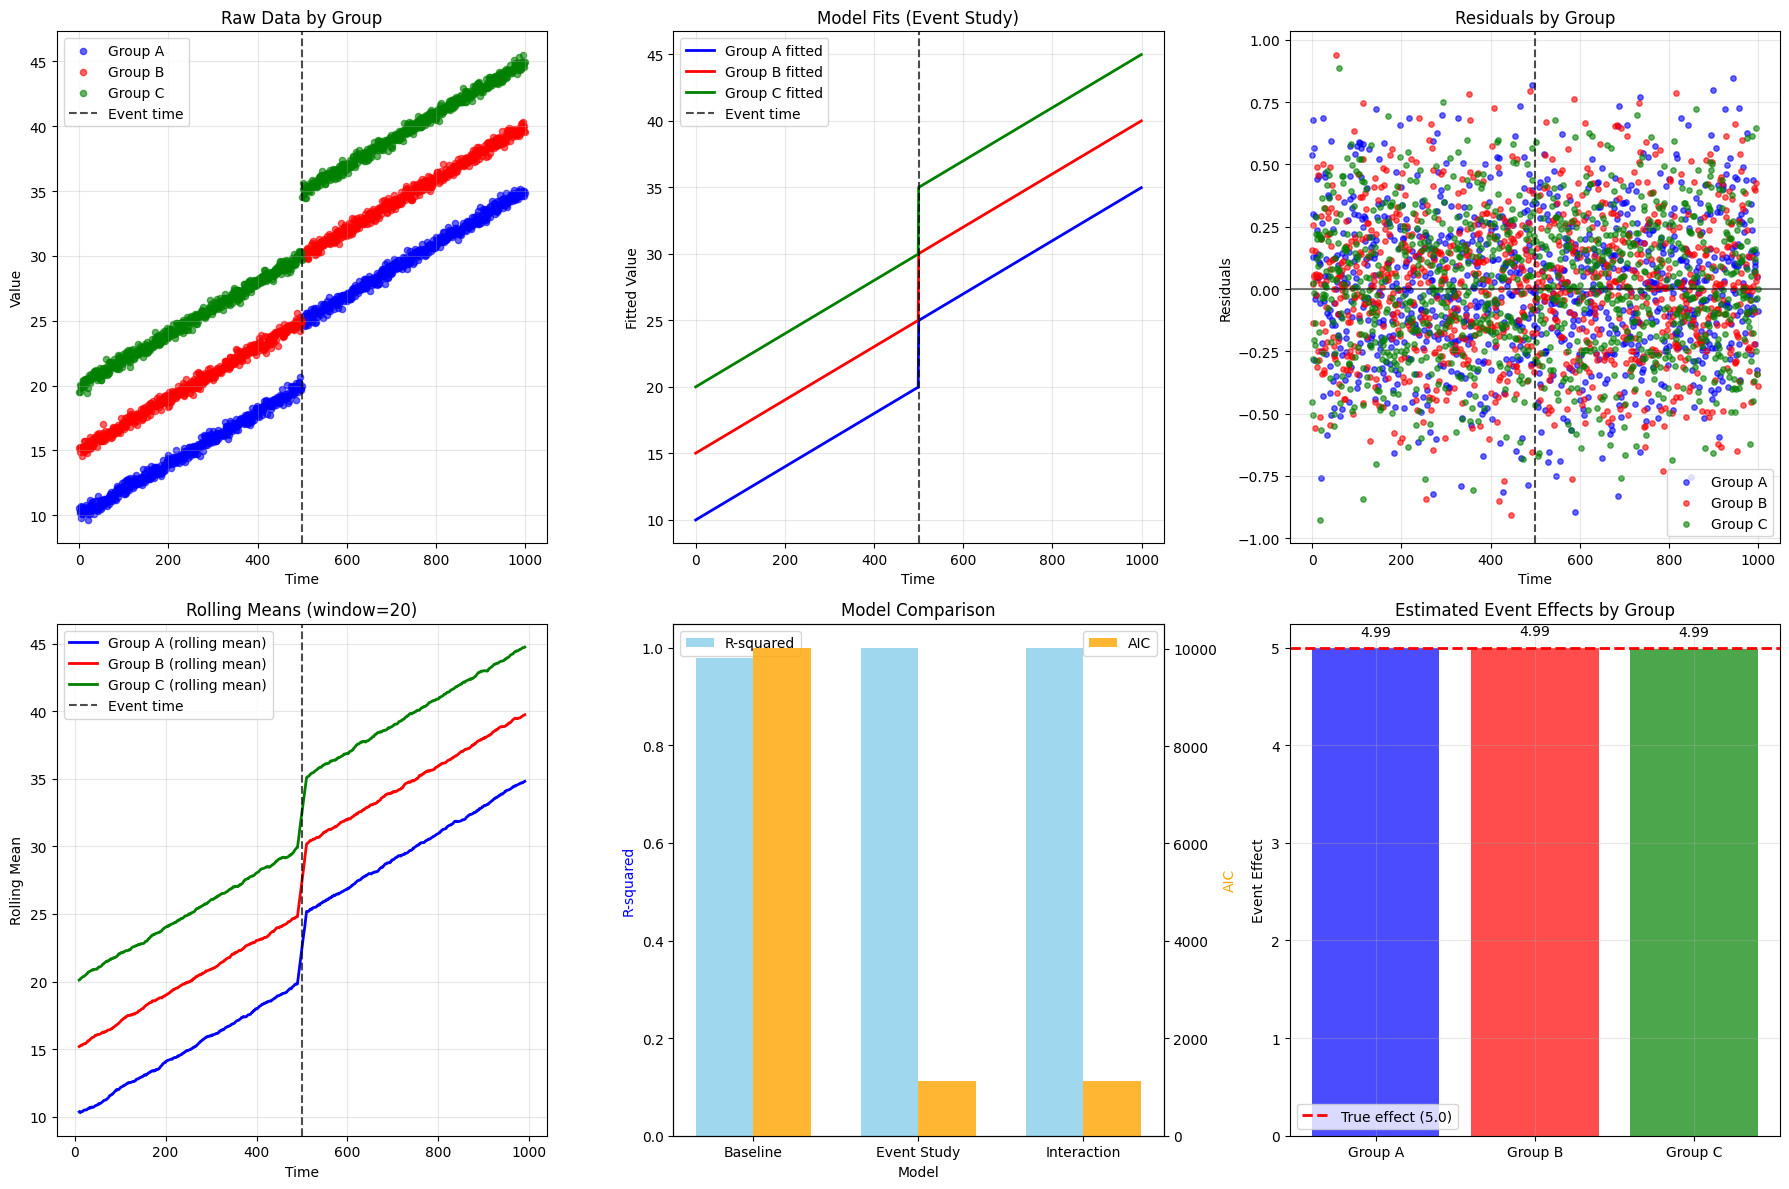

In [110]:
# Create the dataset and run analysis
df_5, df_5_params = construct_three_group_dataset()
models = create_group_fixed_effects_model(df_5, df_5_params)
analyze_group_fixed_effects(df_5, df_5_params, models)
plot_three_group_analysis(df_5, df_5_params, models)

Created three groups with different baseline levels, each with a common trend, a shared event at time 500, and a discontinuous jump after the event. Three models were created after, a baseline (controlling for group differences), an event studies model (adding common effect), and an interaction model (allows for group specific event effects).

Model uses the below formula:\
Y_it = α_i + β*time_t + δ*event_t + ε_it

The model separates three distinct components: 1. Group fixed effects control for time differences between groups, 2. Common trends control for factors affecting groups over time, and 3. Event effect identifies the causal imapct by comparing the before/after periods for each group

## Homework Reflection 12

Construct a dataset in which prior trends do not hold, and in which this makes the differences-in-differences come out wrong.  Explain why the
differences-in-differences estimate of the effect comes out higher or lower than the actual effect.

=== DIFFERENCE-IN-DIFFERENCES ANALYSIS ===

RESULTS:
True treatment effect: 3.000
DiD estimate: 3.929
Bias: 0.929
DiD t-statistic: 15.326
DiD p-value: 0.000000

PRE-TREATMENT TRENDS:
Control group trend: 0.0414
Treatment group trend: 0.0465
Trend difference: 0.0051
(Parallel trends assumption violated!)

WHY DID IS BIASED:
• DiD estimate is HIGHER than true effect
• Treatment group had faster pre-treatment growth
• DiD wrongly attributes this differential trend to treatment
• Bias = 0.0051 * periods_post_treatment

DID CALCULATION BREAKDOWN:
Control: 13.719 - 11.267 = 2.452
Treatment: 15.432 - 9.052 = 6.380
DiD: 6.380 - 2.452 = 3.929


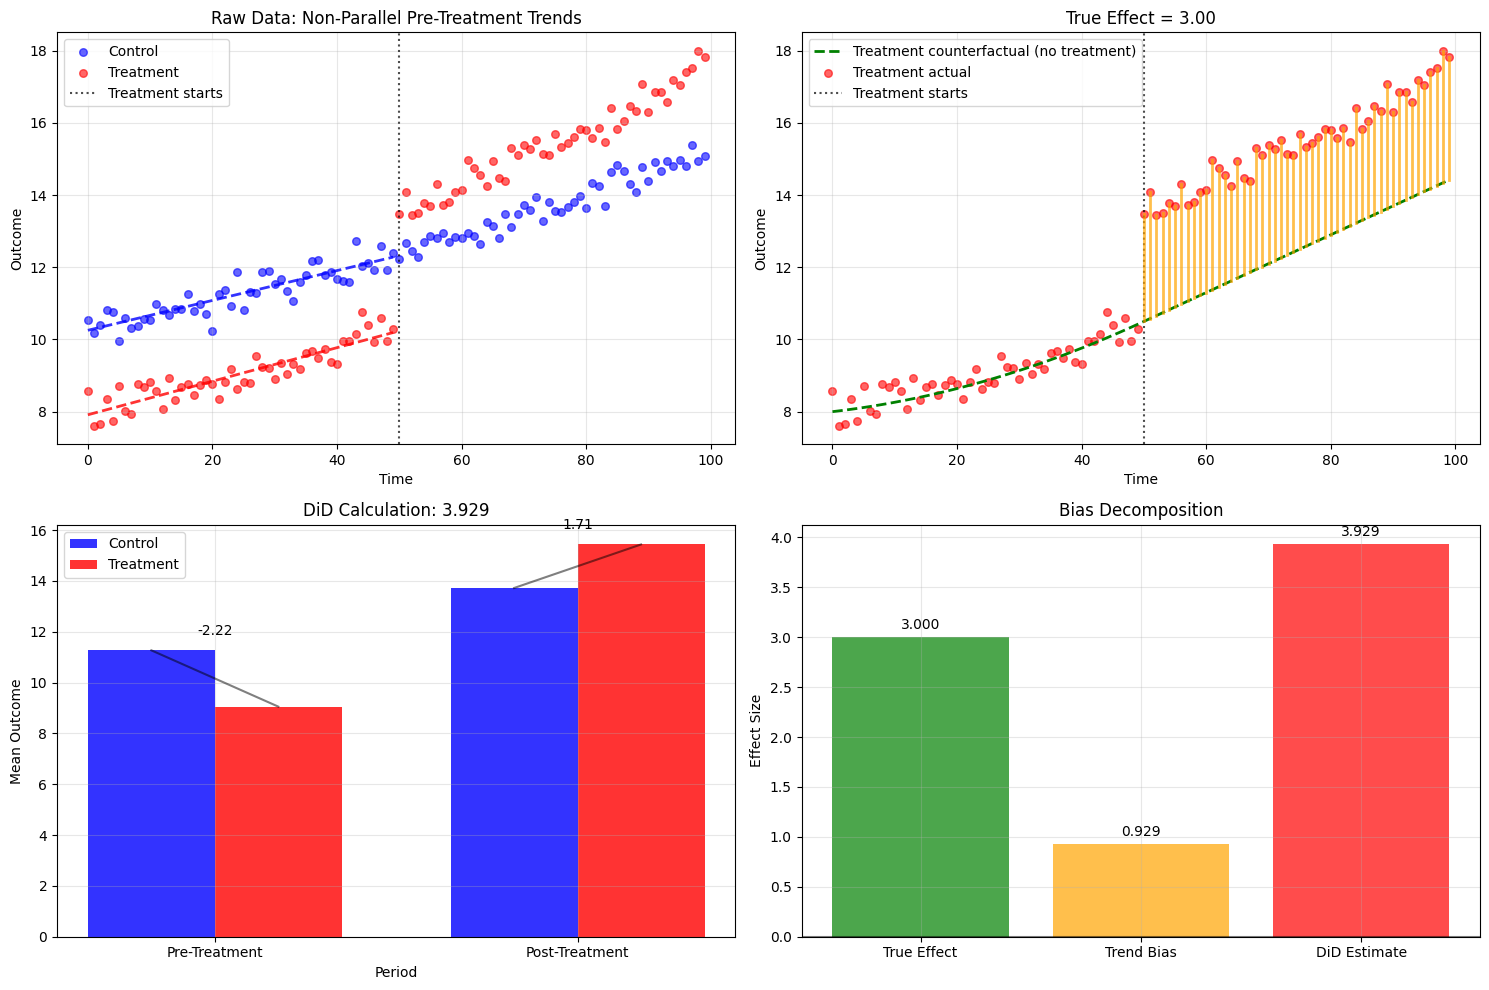

In [102]:
def construct_violated_parallel_trends_dataset(n_periods=100, treatment_time=50, true_effect=3.0):
    """
    Construct dataset where parallel trends assumption is violated
    - Treatment and control groups have different pre-treatment trends
    - This causes DiD to give biased estimates
    """
    np.random.seed(0)
    
    time = np.arange(n_periods)
    
    # Control group: steady upward trend
    control_intercept = 10.0
    control_slope = 0.05
    
    # Treatment group: accelerating trend (violates parallel trends)
    treatment_intercept = 8.0
    treatment_slope_early = 0.02
    treatment_slope_late = 0.08
    
    # Generate control group data
    control_y = control_intercept + control_slope * time
    
    # Generate treatment group data with changing slope
    treatment_y = np.zeros(n_periods)
    for t in range(n_periods):
        if t < treatment_time:
            # Pre-treatment: accelerating trend (violates parallel trends)
            # Linear interpolation between early and late slopes
            current_slope = treatment_slope_early + (treatment_slope_late - treatment_slope_early) * (t / treatment_time)
            treatment_y[t] = treatment_intercept + treatment_slope_early * t + 0.5 * (current_slope - treatment_slope_early) * t
        else:
            # Post-treatment: continue accelerating trend + true treatment effect
            t_since_treatment = t - treatment_time
            pre_treatment_value = (treatment_intercept + 
                                 treatment_slope_early * treatment_time + 
                                 0.5 * (treatment_slope_late - treatment_slope_early) * treatment_time)
            treatment_y[t] = pre_treatment_value + treatment_slope_late * t_since_treatment + true_effect
    
    # Add noise
    noise_level = 0.3
    control_noise = np.random.normal(0, noise_level, n_periods)
    treatment_noise = np.random.normal(0, noise_level, n_periods)
    
    # Create dataset
    data = []
    
    # Control group
    for t in range(n_periods):
        data.append({
            'time': t,
            'group': 'Control',
            'treated': 0,
            'post_treatment': int(t >= treatment_time),
            'y': control_y[t] + control_noise[t],
            'true_counterfactual': control_y[t]  # What treatment group would have been without treatment
        })
    
    # Treatment group  
    for t in range(n_periods):
        # Calculate what treatment group would have been without treatment (counterfactual)
        if t < treatment_time:
            counterfactual = treatment_y[t]
        else:
            t_since_treatment = t - treatment_time
            pre_treatment_value = (treatment_intercept + 
                                 treatment_slope_early * treatment_time + 
                                 0.5 * (treatment_slope_late - treatment_slope_early) * treatment_time)
            counterfactual = pre_treatment_value + treatment_slope_late * t_since_treatment
        
        data.append({
            'time': t,
            'group': 'Treatment',
            'treated': 1,
            'post_treatment': int(t >= treatment_time),
            'y': treatment_y[t] + treatment_noise[t],
            'true_counterfactual': counterfactual
        })
    
    df = pd.DataFrame(data)
    
    return df, {
        'true_effect': true_effect,
        'treatment_time': treatment_time,
        'control_slope': control_slope,
        'treatment_slope_early': treatment_slope_early,
        'treatment_slope_late': treatment_slope_late
    }

def run_difference_in_differences_analysis(df, params):
    """
    Run DiD analysis and show how violated parallel trends leads to bias
    """
    
    # Standard DiD regression
    # Y = β0 + β1*treated + β2*post + β3*(treated*post) + ε
    # β3 is the DiD estimate
    
    df['treated_post'] = df['treated'] * df['post_treatment']
    
    X = df[['treated', 'post_treatment', 'treated_post']]
    X = sm.add_constant(X)
    
    did_model = sm.OLS(df['y'], X).fit()
    did_estimate = did_model.params['treated_post']
    
    # Calculate the true effect at the treatment time
    treatment_data = df[(df['group'] == 'Treatment') & (df['time'] >= params['treatment_time'])]
    true_effects = treatment_data['y'] - treatment_data['true_counterfactual']
    true_effect_avg = true_effects.mean()
    
    # Calculate pre-treatment trend differences
    pre_treatment = df[df['post_treatment'] == 0]
    
    # Fit trends for each group pre-treatment
    control_pre = pre_treatment[pre_treatment['group'] == 'Control']
    treatment_pre = pre_treatment[pre_treatment['group'] == 'Treatment']
    
    # Linear trends
    control_trend = np.polyfit(control_pre['time'], control_pre['y'], 1)[0]
    treatment_trend = np.polyfit(treatment_pre['time'], treatment_pre['y'], 1)[0]
    trend_difference = treatment_trend - control_trend
    
    print("=== DIFFERENCE-IN-DIFFERENCES ANALYSIS ===\n")
    
    print("RESULTS:")
    print(f"True treatment effect: {params['true_effect']:.3f}")
    print(f"DiD estimate: {did_estimate:.3f}")
    print(f"Bias: {did_estimate - params['true_effect']:.3f}")
    print(f"DiD t-statistic: {did_model.tvalues['treated_post']:.3f}")
    print(f"DiD p-value: {did_model.pvalues['treated_post']:.6f}")
    
    print(f"\nPRE-TREATMENT TRENDS:")
    print(f"Control group trend: {control_trend:.4f}")
    print(f"Treatment group trend: {treatment_trend:.4f}")
    print(f"Trend difference: {trend_difference:.4f}")
    print(f"(Parallel trends assumption violated!)")
    
    print(f"\nWHY DID IS BIASED:")
    if did_estimate > params['true_effect']:
        print(f"• DiD estimate is HIGHER than true effect")
        print(f"• Treatment group had faster pre-treatment growth")
        print(f"• DiD wrongly attributes this differential trend to treatment")
        print(f"• Bias = {trend_difference:.4f} * periods_post_treatment")
    else:
        print(f"• DiD estimate is LOWER than true effect")
        print(f"• Treatment group had slower pre-treatment growth") 
        print(f"• DiD wrongly subtracts this differential trend from treatment effect")
    
    # DiD calculation breakdown
    print(f"\nDID CALCULATION BREAKDOWN:")
    
    # Calculate means for 2x2 table
    control_pre_mean = df[(df['group'] == 'Control') & (df['post_treatment'] == 0)]['y'].mean()
    control_post_mean = df[(df['group'] == 'Control') & (df['post_treatment'] == 1)]['y'].mean()
    treatment_pre_mean = df[(df['group'] == 'Treatment') & (df['post_treatment'] == 0)]['y'].mean()
    treatment_post_mean = df[(df['group'] == 'Treatment') & (df['post_treatment'] == 1)]['y'].mean()
    
    control_change = control_post_mean - control_pre_mean
    treatment_change = treatment_post_mean - treatment_pre_mean
    did_manual = treatment_change - control_change
    
    print(f"Control: {control_post_mean:.3f} - {control_pre_mean:.3f} = {control_change:.3f}")
    print(f"Treatment: {treatment_post_mean:.3f} - {treatment_pre_mean:.3f} = {treatment_change:.3f}")
    print(f"DiD: {treatment_change:.3f} - {control_change:.3f} = {did_manual:.3f}")
    
    return {
        'did_estimate': did_estimate,
        'true_effect': params['true_effect'],
        'bias': did_estimate - params['true_effect'],
        'trend_difference': trend_difference,
        'did_model': did_model
    }

def plot_violated_parallel_trends(df, params, results):
    """
    Plot the violation of parallel trends and its impact on DiD
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    treatment_time = params['treatment_time']
    
    # Plot 1: Raw data showing non-parallel trends
    control_data = df[df['group'] == 'Control']
    treatment_data = df[df['group'] == 'Treatment']
    
    axes[0,0].scatter(control_data['time'], control_data['y'], alpha=0.6, color='blue', label='Control', s=30)
    axes[0,0].scatter(treatment_data['time'], treatment_data['y'], alpha=0.6, color='red', label='Treatment', s=30)
    
    # Add trend lines
    pre_control = control_data[control_data['time'] < treatment_time]
    pre_treatment = treatment_data[treatment_data['time'] < treatment_time]
    post_control = control_data[control_data['time'] >= treatment_time]
    post_treatment = treatment_data[treatment_data['time'] >= treatment_time]
    
    # Pre-treatment trends
    if len(pre_control) > 1:
        z_control_pre = np.polyfit(pre_control['time'], pre_control['y'], 1)
        p_control_pre = np.poly1d(z_control_pre)
        axes[0,0].plot(pre_control['time'], p_control_pre(pre_control['time']), 'b--', alpha=0.8, linewidth=2)
    
    if len(pre_treatment) > 1:
        z_treatment_pre = np.polyfit(pre_treatment['time'], pre_treatment['y'], 1)
        p_treatment_pre = np.poly1d(z_treatment_pre)
        axes[0,0].plot(pre_treatment['time'], p_treatment_pre(pre_treatment['time']), 'r--', alpha=0.8, linewidth=2)
    
    axes[0,0].axvline(x=treatment_time, color='black', linestyle=':', alpha=0.7, label='Treatment starts')
    axes[0,0].set_xlabel('Time')
    axes[0,0].set_ylabel('Outcome')
    axes[0,0].set_title('Raw Data: Non-Parallel Pre-Treatment Trends')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # Plot 2: Counterfactual vs actual
    axes[0,1].plot(treatment_data['time'], treatment_data['true_counterfactual'], 'g--', linewidth=2, 
                   label='Treatment counterfactual (no treatment)')
    axes[0,1].scatter(treatment_data['time'], treatment_data['y'], alpha=0.6, color='red', label='Treatment actual', s=30)
    axes[0,1].axvline(x=treatment_time, color='black', linestyle=':', alpha=0.7, label='Treatment starts')
    
    # Highlight the true effect
    post_treatment_data = treatment_data[treatment_data['time'] >= treatment_time]
    for _, row in post_treatment_data.iterrows():
        axes[0,1].plot([row['time'], row['time']], [row['true_counterfactual'], row['y']], 
                      'orange', alpha=0.7, linewidth=2)
    
    axes[0,1].set_xlabel('Time')
    axes[0,1].set_ylabel('Outcome')
    axes[0,1].set_title(f'True Effect = {params["true_effect"]:.2f}')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)
    
    # Plot 3: DiD visualization
    # Create 2x2 means table visualization
    control_pre_mean = df[(df['group'] == 'Control') & (df['post_treatment'] == 0)]['y'].mean()
    control_post_mean = df[(df['group'] == 'Control') & (df['post_treatment'] == 1)]['y'].mean()
    treatment_pre_mean = df[(df['group'] == 'Treatment') & (df['post_treatment'] == 0)]['y'].mean()
    treatment_post_mean = df[(df['group'] == 'Treatment') & (df['post_treatment'] == 1)]['y'].mean()
    
    groups = ['Pre-Treatment', 'Post-Treatment']
    control_means = [control_pre_mean, control_post_mean]
    treatment_means = [treatment_pre_mean, treatment_post_mean]
    
    x = np.arange(len(groups))
    width = 0.35
    
    axes[1,0].bar(x - width/2, control_means, width, label='Control', alpha=0.8, color='blue')
    axes[1,0].bar(x + width/2, treatment_means, width, label='Treatment', alpha=0.8, color='red')
    
    # Add difference lines
    for i in range(len(groups)):
        axes[1,0].plot([x[i] - width/2, x[i] + width/2], 
                      [control_means[i], treatment_means[i]], 'k-', alpha=0.5)
        diff = treatment_means[i] - control_means[i]
        axes[1,0].text(x[i], max(control_means[i], treatment_means[i]) + 0.5, 
                      f'{diff:.2f}', ha='center', va='bottom')
    
    axes[1,0].set_xlabel('Period')
    axes[1,0].set_ylabel('Mean Outcome')
    axes[1,0].set_title(f'DiD Calculation: {results["did_estimate"]:.3f}')
    axes[1,0].set_xticks(x)
    axes[1,0].set_xticklabels(groups)
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)
    
    # Plot 4: Bias decomposition
    bias_components = ['True Effect', 'Trend Bias', 'DiD Estimate']
    values = [params['true_effect'], results['bias'], results['did_estimate']]
    colors = ['green', 'orange', 'red']
    
    bars = axes[1,1].bar(bias_components, values, color=colors, alpha=0.7)
    axes[1,1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1,1].set_ylabel('Effect Size')
    axes[1,1].set_title('Bias Decomposition')
    axes[1,1].grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[1,1].text(bar.get_x() + bar.get_width()/2., height + 0.05 if height >= 0 else height - 0.15,
                      f'{value:.3f}', ha='center', va='bottom' if height >= 0 else 'top')
    
    plt.tight_layout()
    plt.show()

# Create dataset and run analysis
df, params = construct_violated_parallel_trends_dataset()
results = run_difference_in_differences_analysis(df, params)
plot_violated_parallel_trends(df, params, results)